# Moro robustness optimization

In this notebook Moro optimization will be used to find robust policies, that perform well under a wide variety of scenarios.

The notebook consists of 3 major parts:
  1. _Generate random policies_, in which random policies will be generated to see how many scenarios each policy need before the KPIs converge
  2. _Search for candidate solutions_, in which potential robust policies will be searched and found
  3. _Re-evaluate candidate solutions under uncertainty_, to check if the potential policies are actually robust under a higher number of scenarios

3 main KPIs will be used to find these robust policies:

| KPI                           | Max value            | Optimization direction |
|-------------------------------|----------------------|------------------------|
| A.3 Total Costs               | € 170 million        | Minimize               |
| A.3_Expected Number of Deaths | 0.2 (0.001 per year) | Minimize               |
| RfR Total Costs               | € 1950 million       | Minimize               |

## 1. Generate random policies

In this section random policies will be generated to see how many scenarios each policy need before the KPIs converge. First the KPIs are defined, then a function to evaluate if a outcome is robust is defined, the model is generated for our problem formulation, 25 random policies are run for 250 scenarios (generated using latin hypercube sampling) to see how and when the KPIs converged. From that, a computationally acceptable value for the number of scenarios is picked based on how quickly the KPIs converged.

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers

In [2]:
# Set seed to 0 to make notebook reproducable
np.random.seed(0)

In [3]:
# Define the KPIs
years = 200                     # Current preferred timeframe
A3_deaths_per_year = 0.001      # Translates roughly 1 in 100:000 yearly chance of dike breakage in A.3 ring
max_A3_total_costs = 170000000  # Our max preferred costs, based on the potential compensation of Rijkswaterstaat
max_rfr_costs = 1950000000      # Rijkswaterstaat budget of 2.3 billion minus 350 million for our compensation

In [4]:
# Define the robustness function (which evaluates when some outcome is considered acceptable)
def robustness(smaller, threshold, data):
    if smaller:
        return np.sum(data <= threshold) / data.shape[0]
    else:
        return np.sum(data >= threshold) / data.shape[0]

# Define partial functions used to evaluate against
A3_number_of_deaths = functools.partial(robustness, True, A3_deaths_per_year*years)
A3_total_costs = functools.partial(robustness, True, max_A3_total_costs)
RfR_total_costs = functools.partial(robustness, True, max_rfr_costs)

Based on our KPIs problem formulation 3 is the most applicable. It contains information about deaths and costs for the A.3 dike ring. However, it contains a lot of other outcome metrics, which is a potential disadvantage if aggerated metrics are required.

In [5]:
from problem_formulation import get_model_for_problem_formulation

# Get the model for problem formulation 3
model, _ = get_model_for_problem_formulation(3)

In [6]:
# Logging is enabled for debugging purposes
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

With our KPIs defined and model formulated 10 random policies are generated and evaluated over 250 scenarios to see when the KPIs converge to a stable average value. To generate the scenarios, latin hypercube sampling (LHS) is used to ensure a nice spread of scenarios among the uncertainty space, while leaving some randomness in there.

The number of policies and scenarios have been experimentally determined, 25 policies deemed enough to see how multiple different policies stabilize and 250 scenarios was more than enough to see proper convergence of KPIs.

Note that in this notebook [Pickles](https://docs.python.org/3/library/pickle.html) are used to store evaluator results. This allows to quickly iterate on (someone else's) notebook without having to rerun the evaluators each time. If `use_pickle` is set to `True`, the data is loaded from the Pickle file, otherwise the evaluator is run again.

In [7]:
use_pickle1 = True  # Define if the results are loaded or the evaluator is run again
if use_pickle1:
    # Load results from Pickle
    with open('data/moro_rob_results1.pickle', 'rb') as filehandler:
        results1 = pickle.load(filehandler)
else:
    # Run the evaluator to generate new results
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results1 = evaluator.perform_experiments(scenarios=250,
                                                 policies=10,
                                                 uncertainty_sampling=Samplers.LHS)
        # Save the new results in the Pickle file
        with open("data/moro_rob_results1.pickle","wb") as filehandler:
            pickle.dump(results1, filehandler)

To see when KPI convergence is achieved, the average values of each KPI are plotted cumulative with each added scenario.

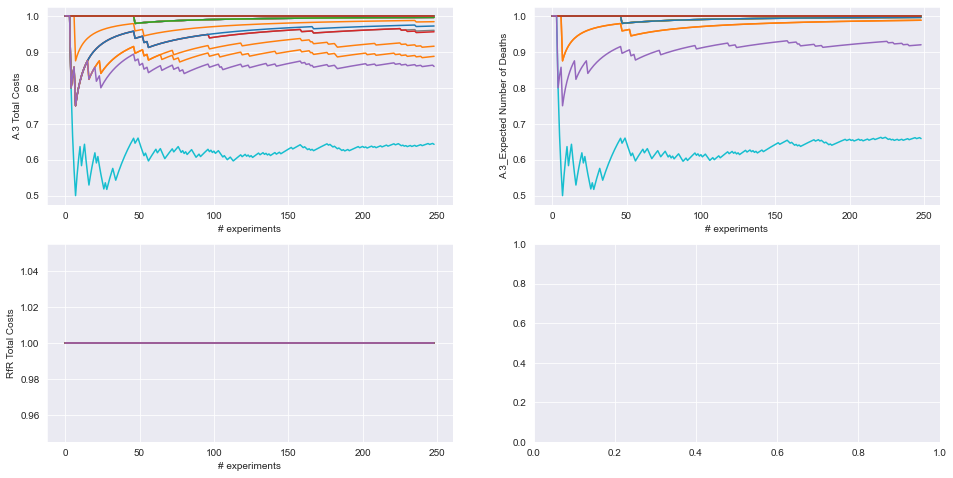

In [8]:
# Define figure with subplots and axes
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,8), sharex=False)
axes = [axes[0,0],axes[0,1],axes[1,0]]

# Define a dictionary linking the outcome keys to the robustness functions
robustness_funcs = {'A.3 Total Costs': A3_total_costs,
                    'A.3_Expected Number of Deaths': A3_number_of_deaths,
                    'RfR Total Costs': RfR_total_costs}

# Split the results tuple in experiments and outcomes
experiments, outcomes = results1

# Select only the outcomes that are also our KPIs
plot_outcomes = {o:v for o,v in outcomes.items() if o in robustness_funcs.keys()}

# Create a subplot for each KPI
for ax, (outcome, value) in zip(axes, plot_outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]

        robustness_p = []

        for i in range(1, data.shape[0]):
            robustness_p.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness_p, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

From the graph above it can be concluded that at least 40 scenarios are needed per policy for the A.3 Total Costs and Expected Number of Deaths to stabilize, and preferably closer to 80 to 100.

## 2. Search for candidate solutions

the fundamental problem is fine tuning the robustness functions. To do this, rather than run optimizaitons many times, why not first generate a test set with a bunch of policies, apply robustness functions and visualize the results?

This gives us much faster feedback on reasonble cutoff values. 


In [9]:
n_scenarios = 40     # Original value: 10 scenarios
n_policies = 50      # Original value: 100 policies
nfe = int(2000)      # Original value: 1000 nfe

In [10]:
from ema_workbench.em_framework import sample_uncertainties

scenarios = sample_uncertainties(model, n_scenarios)

In [11]:
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)

In [12]:
use_pickle2 = True
if use_pickle2:
    with open('data/moro_rob_results2.pickle', 'rb') as filehandler:
        results2 = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results2 = evaluator.perform_experiments(scenarios=n_scenarios,
                                                policies=n_policies)
        # Save results in Pickle file
        with open("data/moro_rob_results2.pickle","wb") as filehandler:
            pickle.dump(results2, filehandler)

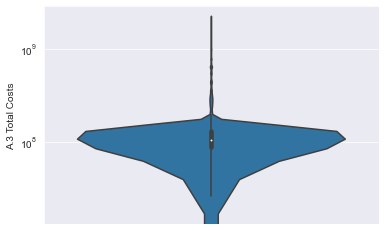

In [13]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='A.3 Total Costs')
ax.set_yscale('log')
plt.show()

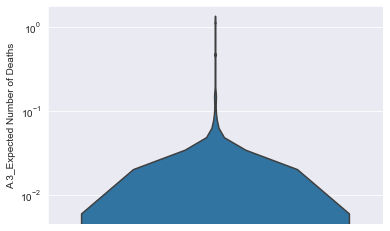

In [14]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='A.3_Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

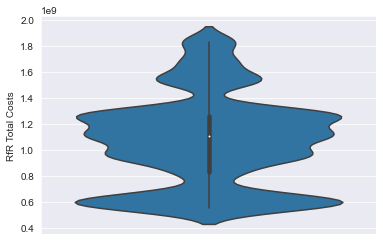

In [15]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='RfR Total Costs')
#ax.set_yscale('log')
plt.show()

## Notebook updated up to here
 - Used problem formulation 3
 - Added constants
 - Rewrote the robustness function
 - Updated pickles and plots

TODO:
 - Try new values for robustness functions below
 - Perform following techniques to determine robustness

In [16]:
#Expected_Number_of_Deaths = functools.partial(robustness, True, 1e-5) #not ok
#Expected_Annual_Damage = functools.partial(robustness, True, 1e4) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
#Total_Investment_Costs = functools.partial(robustness, True, 6e8)#THOSE NUMBERS NEED TO BE SPECIFIED AGAIN

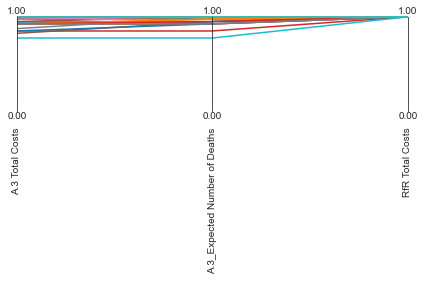

In [17]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results2

funcs = {'A.3 Total Costs': A3_total_costs,
         'A.3_Expected Number of Deaths': A3_number_of_deaths,
         'RfR Total Costs': RfR_total_costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items() if k in robustness_funcs}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits, fontsize=10)
paraxes.plot(data)
plt.show()

In [18]:
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume

convergence = [EpsilonProgress()]
#convergence = [EpsilonProgress(), HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1])]

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'A.3 Total Costs': A3_total_costs,
         'A.3_Expected Number of Deaths': A3_number_of_deaths,
         'RfR Total Costs': RfR_total_costs}

robustnes_functions = [ScalarOutcome('A.3 Total Costs', kind=MINIMIZE,
                                     function=A3_total_costs),
                       ScalarOutcome('A.3_Expected Number of Deaths', kind=MINIMIZE,
                                     function=A3_number_of_deaths),
                       ScalarOutcome('RfR Total Costs', kind=MINIMIZE,
                                     function=RfR_total_costs),
                      ]

epsilons=[0.025]*len(funcs)  #final value of epsilon should be much lower.Just for experiment purposes is 1

use_pickle3 = True
if use_pickle3:
    with open('data/moro_rob_results3.pickle', 'rb') as filehandler:
        results3 = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results3 = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe, convergence=convergence, epsilons=epsilons, convergence_freq=25, logging_freq=1)
        # Save results in Pickle file
        with open("data/moro_rob_results3.pickle","wb") as filehandler:
            pickle.dump(results3, filehandler)
archive, convergence = results3

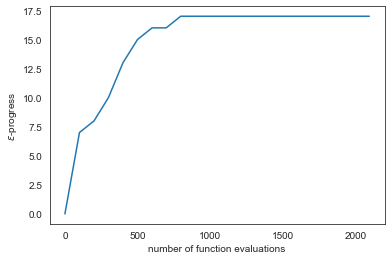

In [19]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [20]:
archive

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.3 Total Costs,A.3_Expected Number of Deaths,RfR Total Costs
0,1,0,0,1,0,1,0,0,0,0,...,0,3,3,4,7,1,4,0.5,0.45,1.0


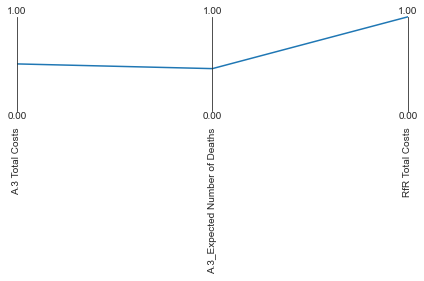

In [21]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits, fontsize=10)
paraxes.plot(data)
plt.show()

This is a bit better but not much. 

Now, observe the following: you are using a domain criterion as your sole measure of robustness. That is, you look at the fraction of scenarios above or below a threshold. The costs however do not vary accross scenarios. Thus this objective can only be 0 or 1. This is not particularly useful for optimization. 

We might thus want to consider another metric for costs. Why not simply use the raw costs itself?


In [22]:
data

,A.3 Total Costs,A.3_Expected Number of Deaths,RfR Total Costs
0,0.5,0.45,1.0


In [23]:
import functools

def costs(data):
    return data[0]/1e9 # makes numbers nicer

A3_number_of_deaths = functools.partial(robustness, True, A3_deaths_per_year*years)
A3_total_costs = functools.partial(robustness, True, max_A3_total_costs)
RfR_total_costs = costs

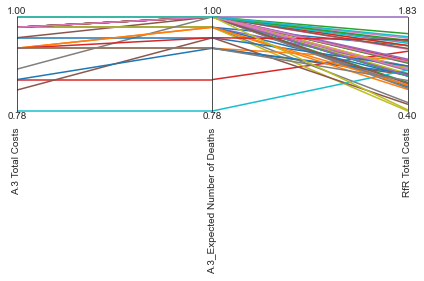

In [24]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results2

funcs = {'A.3 Total Costs': A3_total_costs,
         'A.3_Expected Number of Deaths': A3_number_of_deaths,
         'RfR Total Costs': RfR_total_costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy

    temp_outcomes = {k:v[logical] for k,v in outcomes.items() if k in robustness_funcs}

    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits, fontsize=10)
paraxes.plot(data)
plt.show()

This already looks much nicer.

In [25]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'A.3 Total Costs': A3_total_costs,
         'A.3_Expected Number of Deaths': A3_number_of_deaths,
         'RfR Total Costs': RfR_total_costs}

robustnes_functions = [ScalarOutcome('A.3 Total Costs', kind=MINIMIZE,
                                     function=A3_total_costs),
                       ScalarOutcome('A.3_Expected Number of Deaths', kind=MINIMIZE,
                                     function=A3_number_of_deaths),
                       ScalarOutcome('RfR Total Costs', kind=MINIMIZE,
                                     function=RfR_total_costs)]

In [26]:
use_pickle4 = True
if use_pickle4:
    with open('data/moro_rob_results4.pickle', 'rb') as filehandler:
        results4 = pickle.load(filehandler)
else:
    # we have to change the plausible max for total investment costs
    convergence = [EpsilonProgress()]

    epsilons=[0.025]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results4 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe, convergence=convergence, epsilons=epsilons, convergence_freq=25, logging_freq=1)
    # Save results in Pickle file
    with open("data/moro_rob_results4.pickle","wb") as filehandler:
        pickle.dump(results4, filehandler)
archive, convergence = results4

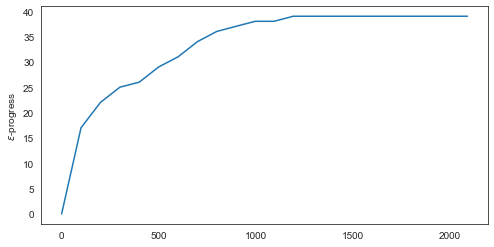

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

plt.show()

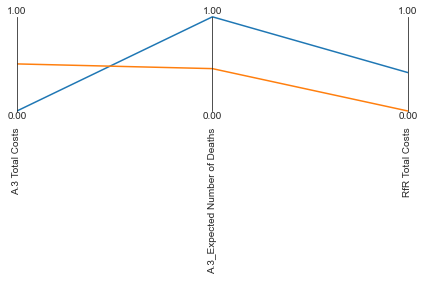

In [28]:
data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits, fontsize=10)
paraxes.plot(data)
plt.show()

## 3. Re-evaluate candidate solutions under uncertainty

In [29]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(f"Moro {i}", **policy.to_dict()))
len(policies_to_evaluate)

2

In [30]:
use_pickle5 = True
if use_pickle5:
    with open('data/moro_rob_results5.pickle', 'rb') as filehandler:
        results5 = pickle.load(filehandler)
else:
    n_scenarios = 1000  # Original value: 1000
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results5 = evaluator.perform_experiments(n_scenarios,
                                                policies_to_evaluate)
        # Save results in Pickle file
        with open("data/moro_rob_results5.pickle","wb") as filehandler:
            pickle.dump(results5, filehandler)
#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

In [31]:
from ema_workbench import save_results

save_results(results5, 'data/MORO_rob_reevaluation.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\Ewout\Documents\GitHub\modelbased-g13\data\MORO_rob_reevaluation.tar.gz


In [32]:
policies.to_csv('data/MORO_rob_polices.csv')

with open("results/moro_robust_policies.pickle","wb") as filehandler:
    pickle.dump(policies_to_evaluate, filehandler)

In [33]:
import pandas as pd
experiments, outcomes = results5

overall_robustness = {}
plot_outcomes = {o:v for o,v in outcomes.items() if o in robustness_funcs.keys()}

for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        if outcome in robustness_funcs.keys():
            values = values[logical]
            policy_robustness[outcome] = robustness_funcs[outcome](values)
        overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

,A.3 Total Costs,A.3_Expected Number of Deaths,RfR Total Costs
moro 0,0.00,1.00,1.0
moro 1,0.52,0.41,1.0


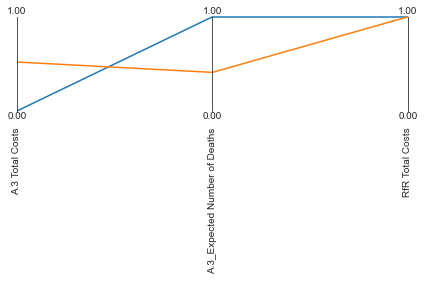

In [34]:
data = overall_robustness.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits, fontsize=10)
paraxes.plot(data)
plt.show()